![This is an image](img/IP-Paris.png)

# RAMP on Taxi Fare Prediction 

_Authors: Xavier Brouty, Balthazar Courvoisier, Hugo Dèbes, Yassine Hargane, Rita-Mathilda Kabro, Baptiste Pasquier_

1. [Introduction](#1.-Introduction)
2. [The prediction task](#2.-The-prediction-task)
3. [Installation of libraries](#3.-Installation-of-libraries) : To do before coming!
4. [The data](#4.-Data-Analysis-and-Feature-Engineering)
5. [The pipeline](#5.-The-pipeline)
6. [Evaluation](#6.-Evaluation)
7. [Local testing/exploration](#7.-Testing-the-submission)
8. [Submission](#8.-Submission)

# 1. Introduction

The goal of this ramp is to predict the fare of a taxi ride in New York City during the month of may 2022. The price is display in dollars and you are given several informations such as the coordinates of the zones of pickup and dropoff, the time of the course, the number of passengers. As a real use case, you will only have access to the information prior to the ride and will only be able to estimate features like the distance for example.

![map](img/example_map.png)


The database comes from the official website of the city of New York where they upload the records for eah month. In a matter of easy data volume to deal with, we focused ourselves on one representative month. As

The price of a taxi ride can often lead to surprises when people are not aware prior to them. In such a dense agglomeration, with more than 13 000 cabs, we think Machine Learning can help to draw a clear picture of the price.

You have also been given this public document written by the New York City Hall stating applicable surcharge on taxi rides.

![rules](img/rules_pt1.png)



# 2. The prediction Task

Taxi fares are computed in several different ways and they often include seasonality during holidays or weekends. Plus, your task will be to estimate how the distance travelled can impact the price of the ride. On the dataset, this information is not given as in the future we would like to predict the price before the ride and a taxi can take several roads. There is multiple ways to compute the distance and we'll present one in the next section. 

A taxi ride can also be affected by the neighborood they began, travelled and ended the ride. For example, in New York, the south of Manhattan is highly dense and likely to be saturated leading to a possible surcharge in the price. To quantify the density of a district, we used the point of interest but several other approaches exist. 

Finally, the weather can play a role in the demand and the times spent to perform a ride. If heavy rains are ongoing, it would make sense create congestion on the road leading to an increase in the price. 

# 3. Installation of libraries

To get this notebook running and test your models locally using the ramp_test_submission, we recommend that you use the Python distribution from Anaconda or Miniconda. (uncomment the lines before running them)



In [1]:
# !conda install -y -c conda conda-env     # First install conda-env to ease the creation of virtual envs in conda
# !conda env create                        # Uses the local environment.yml to create the 'taxi_fare' env

OR if you have Python already installed but are not using Anaconda, you'll want to use pip

In [2]:
# !pip install -r requirements.txt

Installation of ramp-workflow

For being able to test submissions, you also need to have the ramp-workflow package locally. You can install the latest version with pip from github:



In [3]:
# !pip install git+https://github.com/paris-saclay-cds/ramp-workflow

# 4. Data Analysis and Feature Engineering

To get interactive map with Folium, use `INTERACTIVE_MAP = True`

In [4]:
%reload_ext autoreload
%autoreload 2

from random import randint

import contextily as cx
import geopandas as gpd
import holidays
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import rampwf as rw
import seaborn as sns
from IPython.display import HTML, display
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from problem import get_poi_data, get_train_data, get_weather_data, get_zone_data

INTERACTIVE_MAP = False

### 4.1. Get the Data

In [5]:
X_train, y_train = get_train_data()

## 4.2. Preliminary observations

In [6]:
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852944 entries, 0 to 2852943
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   PULocationID           int64         
 5   DOLocationID           int64         
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 130.6 MB


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2022-05-12 21:19:50   2022-05-12 21:23:46              1.0   
1         2  2022-05-03 15:21:34   2022-05-03 15:28:56              1.0   
2         2  2022-05-10 10:50:21   2022-05-10 11:06:07              1.0   
3         1  2022-05-15 12:28:05   2022-05-15 12:49:04              1.0   
4         2  2022-05-16 00:41:32   2022-05-16 00:51:44              1.0   

   PULocationID  DOLocationID  
0            90           158  
1            48           246  
2           141           162  
3           148           186  
4           246            48

The data consist of 19 variables. The pickup datetime and the dropoff datetime, but also the trip distance, the passager count, and several variables enabling you to known of the presence of any surcharge (airport fees for instance).  

Each row of the dataframe represent one single course.

Here is the description of each columns:

- vendorID: A code indicating the TPEP provider that provided the record. (1= Creative Mobile Technologies, LLC; 2= VeriFone Inc)
- tpep_pickup_datetime: The date and time when the meter was engaged.
- tpep_dropoff_datetime: The date and time when the meter was disengaged.
- passenger_count: The number of passengers in the vehicle.
- PULocationID: TLC Taxi Zone in which the taximeter was engaged
- DOLocationID: TLC Taxi Zone in which the taximeter was disengaged 

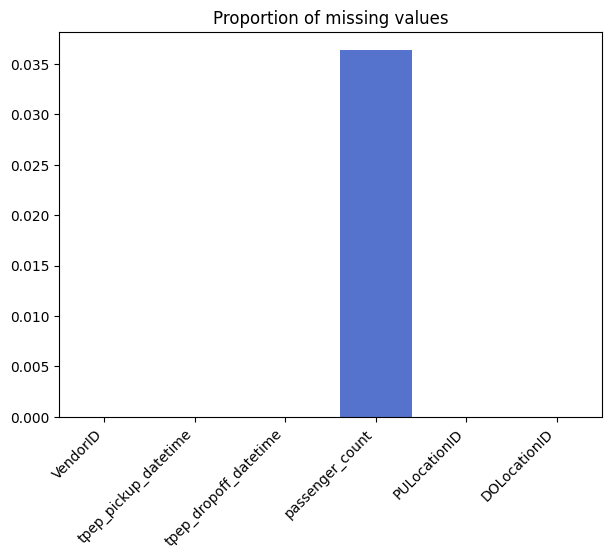

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.barplot(
    x=X_train.columns,
    y=X_train.isna().sum() / X_train.shape[0],
    color="royalblue",
    ax=ax,
)
ax.set_xticklabels(X_train.columns, rotation=45, ha="right")
ax.set_title("Proportion of missing values")
plt.show()

In terms of null values, they touched a small proportion of rides on the `passenger_count` attribute. We will simply replace it by a random number between 1 and 3.

In [8]:
X_train.passenger_count = np.where(
    X_train.passenger_count.isna(), randint(1, 3), X_train.passenger_count
)

The target is the total amount paid in dollars by the user :

In [9]:
y_train.head()

0    10.56
1    10.30
2    15.30
3    17.75
4    12.80
Name: total_amount, dtype: float64

### The cost of trips 

In [10]:
print(
    "The median price is",
    round(y_train.quantile(0.5), 2),
    "dollars",
)

The median price is 16.3 dollars


In [11]:
y_train.describe()

count    2.852944e+06
mean     2.232082e+01
std      1.781355e+01
min      1.100000e+00
25%      1.236000e+01
50%      1.630000e+01
75%      2.376000e+01
max      1.314800e+03
Name: total_amount, dtype: float64

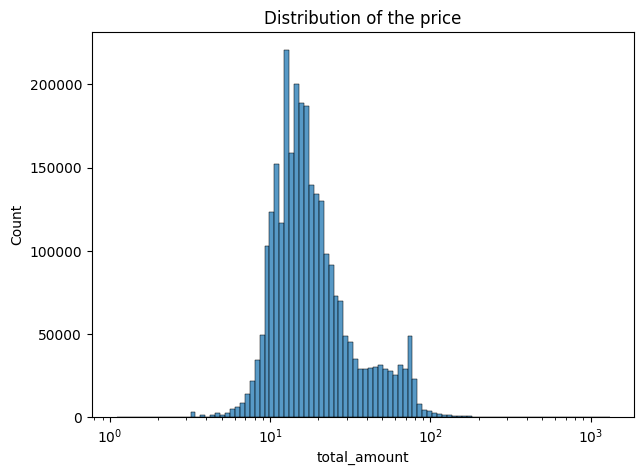

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(x=y_train, log_scale=True, bins=100, ax=ax)
ax.set_title("Distribution of the price")
plt.show()

## 4.3. Temporal Analysis

After cleaning and getting used to the data, we wanted to evaluate how the price was evolving depending on the time of the ride. We will focus our analysis on 3 different questions: 

- How does the price evolve during the weekend ?
- Do Bank Holidays have an impact on the price ?
- How does the price evolve throughout the day ?

To illustrate the first question, we plotted the number of rides (on the left) and the average price (on the right) of the taxi rides. We colored the the bar in orange when the day was either Saturday or Sunday. 

In [13]:
X_train["fg_weekends"] = np.where(
    X_train.tpep_pickup_datetime.dt.weekday >= 5, True, False
)

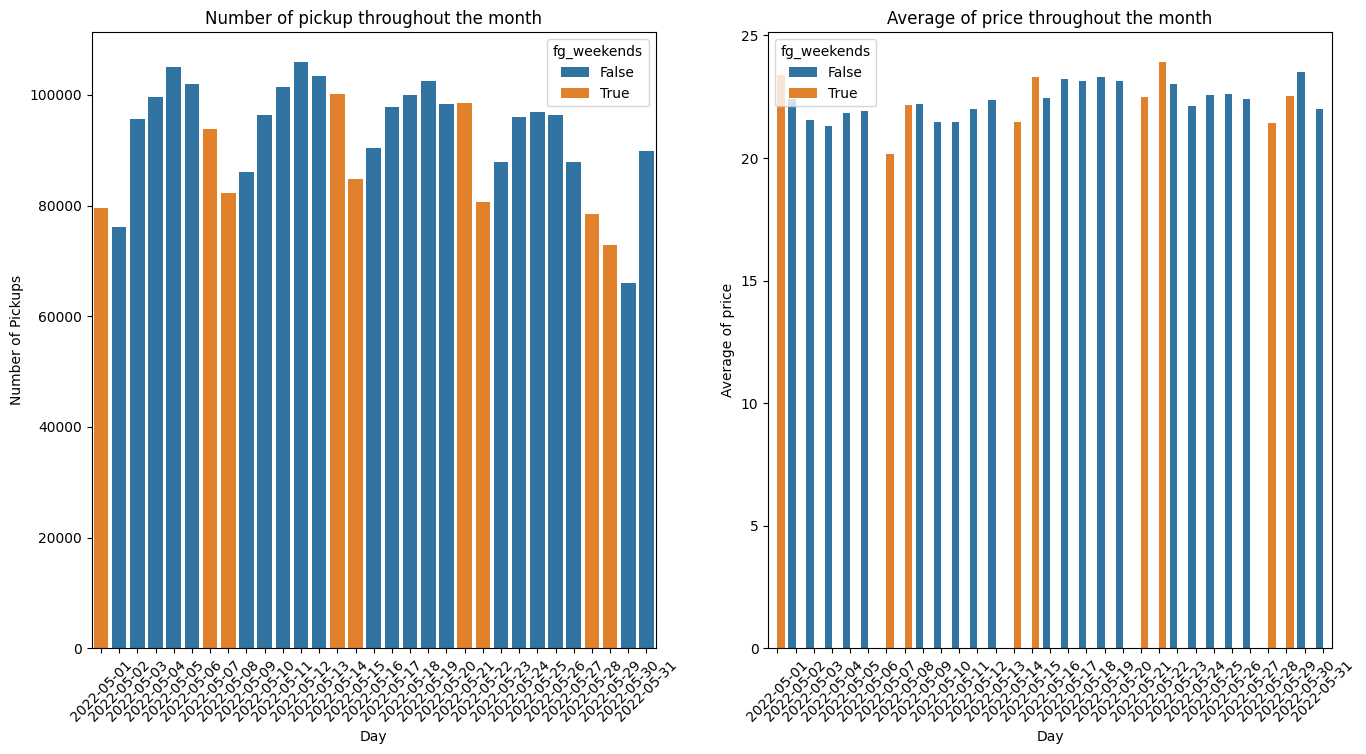

In [14]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 8))

df_temp = pd.concat((X_train, y_train), axis=1)
df_temp = (
    df_temp.groupby(df_temp.tpep_pickup_datetime.dt.date)
    .agg({"VendorID": "count", "total_amount": "mean", "fg_weekends": "max"})
    .sort_index()
    .reset_index()
)

sns.barplot(
    x="tpep_pickup_datetime",
    y="VendorID",
    data=df_temp,
    hue="fg_weekends",
    dodge=False,
    ax=axes[0],
)
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Number of Pickups")
axes[0].set_title("Number of pickup throughout the month")
axes[0].tick_params(axis="x", rotation=45)


sns.barplot(
    x="tpep_pickup_datetime",
    y="total_amount",
    data=df_temp,
    hue="fg_weekends",
    ax=axes[1],
)
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Average of price")
axes[1].set_title("Average of price throughout the month")
axes[1].tick_params(axis="x", rotation=45)

plt.show()

We notice a seasonality on the number of pickups where the number increases from Monday to Thursday and then dropping from Friday until the end of the week. On the other hand, the prices remain at the same level throughout the week. However, we can even detect a variation when it comes to the weekend. The prices drop on the Saturdays an increase on the Sundays to an high of almost 25$ in average per ride. 

To illustrate this variation, we decided to create a boolean value whether the ride happens on weekdays or during the weekend names `fg_weekends`.

Lastly, on the left graph, every average on Sunday is above the Monday except for the last week of may. It can be explain as the Monday 30th May 2022 was a bank holiday in the United States. Indeed, it was the Memorial Day and this abrupt change in our data encourage us to take this information into account. It seems logical that taxi drivers will charge a bit more for a ride during holidays. We created a boolean from the __holidays__ package to indicate weather it is a bank holidays or not.

To better understand how the number of pickups and the price evolved, we zoomed on the usual Mondays and compared it to the Memorial Day.

In [15]:
day_week = {
    0: "monday",
    1: "tuesday",
    2: "wednesday",
    3: "thursday",
    4: "friday",
    5: "saturday",
    6: "sunday",
}

In [16]:
us_holidays = holidays.UnitedStates(years=2022, subdiv="NY")

In [17]:
bank_holidays_month_ny = [date for date, _ in us_holidays.items() if date.month == 5]

In [18]:
X_train["fg_bank_holidays"] = np.where(
    X_train.tpep_pickup_datetime.dt.date.isin(bank_holidays_month_ny), True, False
)

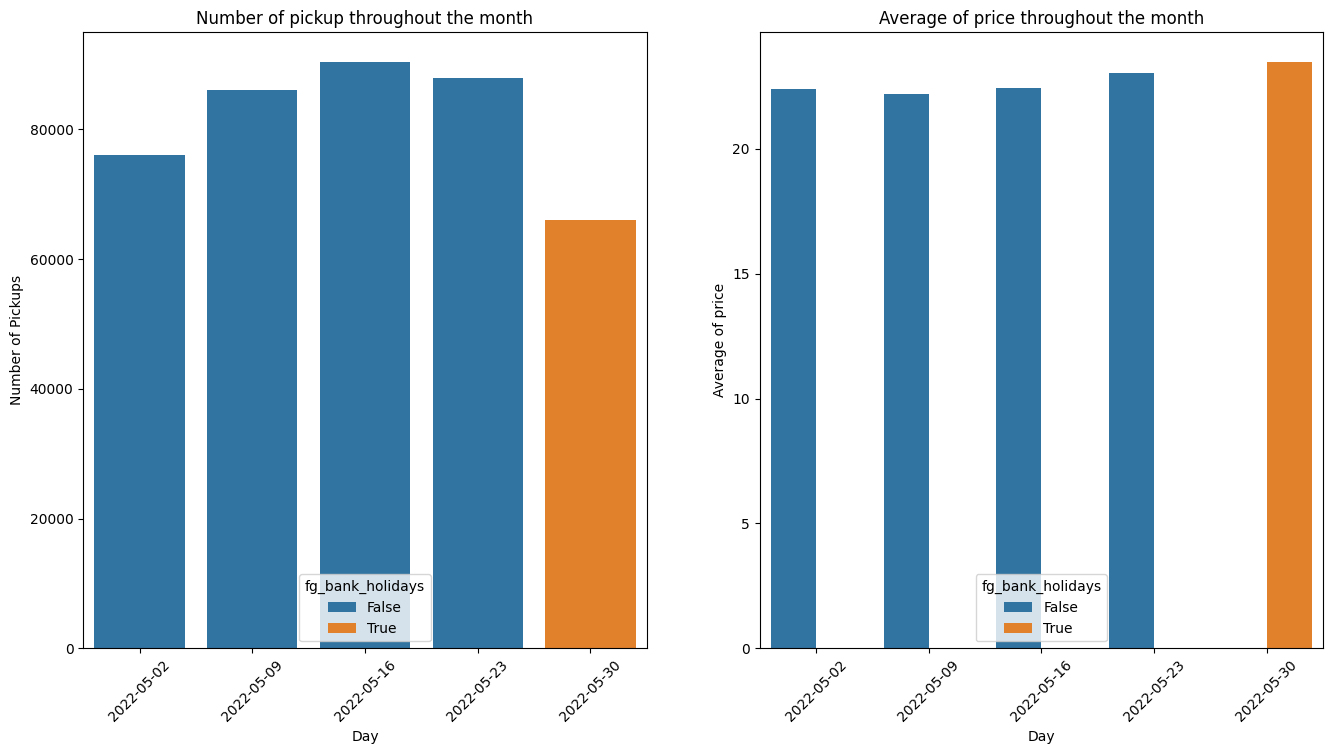

In [19]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 8))

df_temp = pd.concat((X_train, y_train), axis=1)
df_temp = df_temp.loc[(df_temp.tpep_pickup_datetime.dt.weekday == 0)]
df_temp = (
    df_temp.groupby(df_temp.tpep_pickup_datetime.dt.date)
    .agg({"VendorID": "count", "total_amount": "mean", "fg_bank_holidays": "max"})
    .sort_index()
    .reset_index()
)

sns.barplot(
    x="tpep_pickup_datetime",
    y="VendorID",
    data=df_temp,
    hue="fg_bank_holidays",
    dodge=False,
    ax=axes[0],
)
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Number of Pickups")
axes[0].set_title("Number of pickup throughout the month")
axes[0].tick_params(axis="x", rotation=45)


sns.barplot(
    x="tpep_pickup_datetime",
    y="total_amount",
    data=df_temp,
    hue="fg_bank_holidays",
    ax=axes[1],
)
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Average of price")
axes[1].set_title("Average of price throughout the month")
axes[1].tick_params(axis="x", rotation=45)

plt.show()

It confirms our first observation. The bank holidays do impact on the prediction and we choose to keep this indicator.

We worked on a day granularity, aggregating our data on a 24h basis but it is common knowledge that the price can evolve in function of the hour of the day. We plotted the average price per hour of the day and split it in function of the day in the following graph.

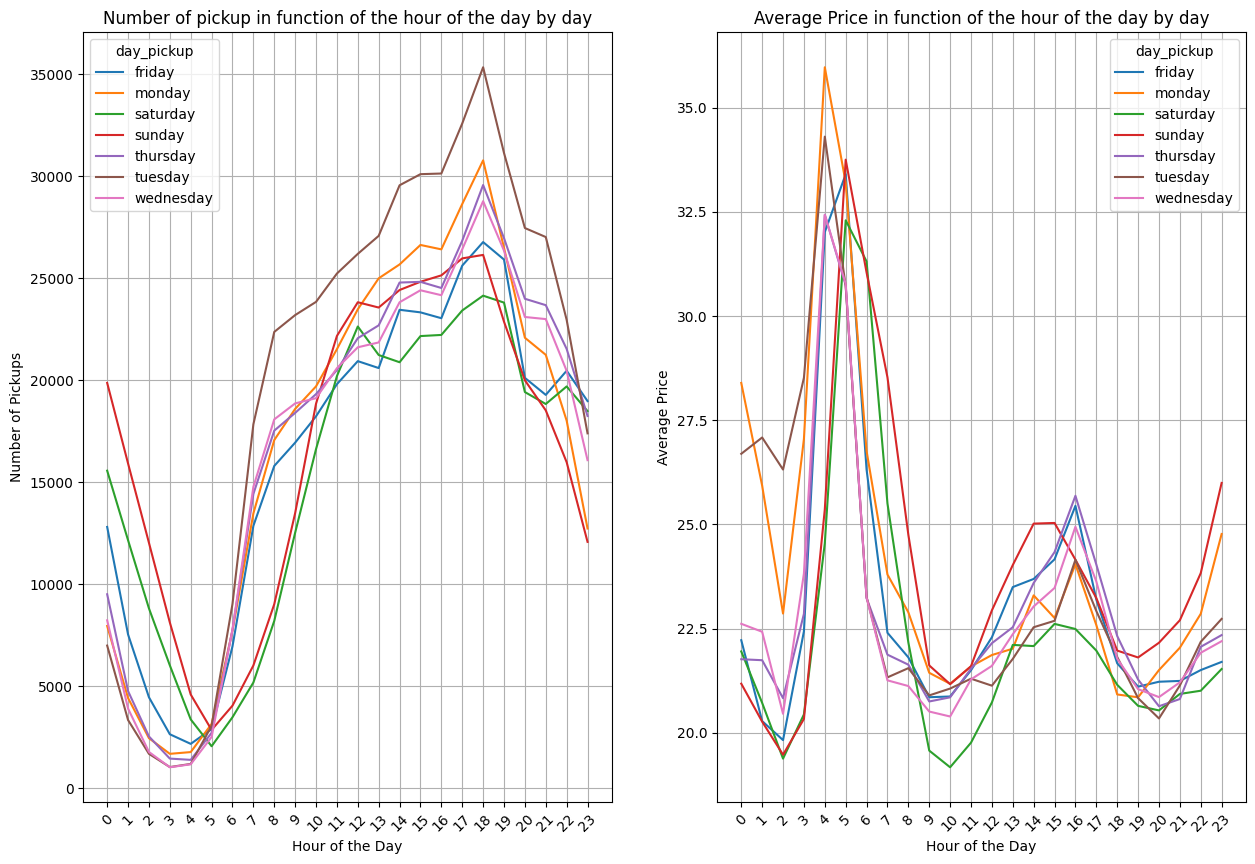

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

df_temp = pd.concat((X_train, y_train), axis=1)
df_temp["hour_pickup"] = df_temp.tpep_pickup_datetime.dt.hour
df_temp["day_pickup"] = df_temp.tpep_pickup_datetime.dt.dayofweek
df_temp = (
    df_temp.groupby(["day_pickup", "hour_pickup"])
    .agg({"VendorID": "count", "total_amount": "mean"})
    .reset_index()
)
df_temp = df_temp.sort_values("day_pickup")
df_temp.day_pickup = df_temp.day_pickup.map(day_week)


df_temp1 = df_temp.pivot(index="hour_pickup", columns="day_pickup", values="VendorID")
df_temp1.plot(xticks=df_temp1.index, ylabel="VendorID", ax=axes[0])
axes[0].set_xlabel("Hour of the Day")
axes[0].set_ylabel("Number of Pickups")
axes[0].set_title("Number of pickup in function of the hour of the day by day")
axes[0].grid()
axes[0].tick_params(axis="x", rotation=45)


df_temp2 = df_temp.pivot(
    index="hour_pickup", columns="day_pickup", values="total_amount"
)
df_temp2.plot(xticks=df_temp2.index, ylabel="VendorID", ax=axes[1])
axes[1].set_xlabel("Hour of the Day")
axes[1].set_ylabel("Average Price")
axes[1].set_title("Average Price in function of the hour of the day by day")
axes[1].grid()
axes[1].tick_params(axis="x", rotation=45)

plt.show()

In terms of traffic, unsurprisingly, we reached a low point arond 4am where the vast majority of the population is sleeping. We notice how the weekend is still busy compared to the rest of the days due to people getting back home after spending the evening out. We almost have the oppposite curve when it comes to the price where the highest point is reached in the middle of the night. Two factors can explain it. First, a low offer as most taxi does not work past a certain time combined with a relatively high demand due to the lively night-life in NYC. Secondly, on top of this natural increase in prices, the taxi drivers apply a surcharge for overnight rides. In this public document from the city hall of NY, we read:

> Plus $1.00 overnight surcharge 8pm to 6am.

We add a boolean when a ride occurs in this timerange.

In [21]:
X_train["fg_overnight"] = np.where(
    (X_train.tpep_pickup_datetime.dt.hour > 20)
    | (X_train.tpep_pickup_datetime.dt.hour < 6),
    True,
    False,
)

The number starts to increases as people are waking up and commuting to their work. We reached the highest number during the rush hours. Surprinsingly, it's the Tuesday that see the highest number of rides where we thought it would been a Friday or Monday. Price-wise, they increase during the rush hour period. Again, it can be explained as many people are trying to use them while the offer does not increase. Plus using again, the public document from the city hall, we have:
> Plus $2.50 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.

Once again, we added a boolean when a ride meets such condition. 

In [22]:
X_train["fg_rush_hour"] = np.where(
    (X_train.tpep_pickup_datetime.dt.hour < 20)
    & (X_train.tpep_pickup_datetime.dt.hour > 16)
    & (X_train.fg_weekends is False)
    & (X_train.fg_bank_holidays is False),
    True,
    False,
)

## 4.4. Spatial Analysis

Each taxi trip is characterized by a starting zone (pickup) `PULocationID` and an arrival zone (dropoff) `DOLocationID`.

In [23]:
X_train[["DOLocationID", "PULocationID"]]

DOLocationID  PULocationID
0                 158            90
1                 246            48
2                 162           141
3                 186           148
4                  48           246
...               ...           ...
2852939           142           151
2852940           263            43
2852941           148           161
2852942           142            48
2852943            43           148

[2852944 rows x 2 columns]


### 4.4.1. Zone data


The zones are numbered from 1 to 265 and correspond to a geographical division of New York.

The `get_zone_data` function allows you to recover additional information from the 265 zones, in particular geographic coordinates.

In [24]:
df_zone = get_zone_data()
df_zone

Borough                     Zone service_zone  Shape_Leng  \
LocationID                                                                    
1                     EWR           Newark Airport          EWR    0.116357   
2                  Queens              Jamaica Bay    Boro Zone    0.433470   
3                   Bronx  Allerton/Pelham Gardens    Boro Zone    0.084341   
4               Manhattan            Alphabet City  Yellow Zone    0.043567   
5           Staten Island            Arden Heights    Boro Zone    0.092146   
...                   ...                      ...          ...         ...   
261             Manhattan       World Trade Center  Yellow Zone    0.027120   
262             Manhattan           Yorkville East  Yellow Zone    0.049064   
263             Manhattan           Yorkville West  Yellow Zone    0.037017   
264               Unknown                       NV          NaN         NaN   
265               Unknown                      NaN          NaN         NaN   

            Shape_Area                                           geometry  
LocationID                                                                 
1             0.000782  POLYGON ((933100.918 192536.086, 933091.011 19...  
2             0.004866  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
3             0.000314  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
4             0.000112  POLYGON ((992073.467 203714.076, 992068.667 20...  
5             0.000498  POLYGON ((935843.310 144283.336, 936046.565 14...  
...                ...                                                ...  
261           0.000034  POLYGON ((980555.204 196138.486, 980570.792 19...  
262           0.000122  MULTIPOLYGON (((999804.795 224498.527, 999824....  
263           0.000066  POLYGON ((997493.323 220912.386, 997355.264 22...  
264                NaN                                               None  
265                NaN                                               None  

[265 rows x 6 columns]

In [25]:
def plot_geometry(
    df,
    column=None,
    geometry="geometry",
    interactive=INTERACTIVE_MAP,
    title="",
    **kwargs,
):
    if isinstance(df, gpd.GeoDataFrame):
        gdf = df[df[geometry].notna()].copy()
        gdf.set_geometry(geometry)
    else:
        gdf = gpd.GeoDataFrame(df[df[geometry].notna()], geometry=geometry).set_crs(
            "EPSG:2263"
        )

    if interactive:
        if title:
            display(HTML(f"<h3>{title}</h3>"))
        display(gdf.explore(column=column, tiles="CartoDB positron", **kwargs))

    else:
        ax = gdf.plot(column=column, figsize=(8, 8), legend=True, **kwargs)
        cx.add_basemap(ax, crs=gdf.crs, source="CartoDB positron")
        plt.title(title)
        plt.show()

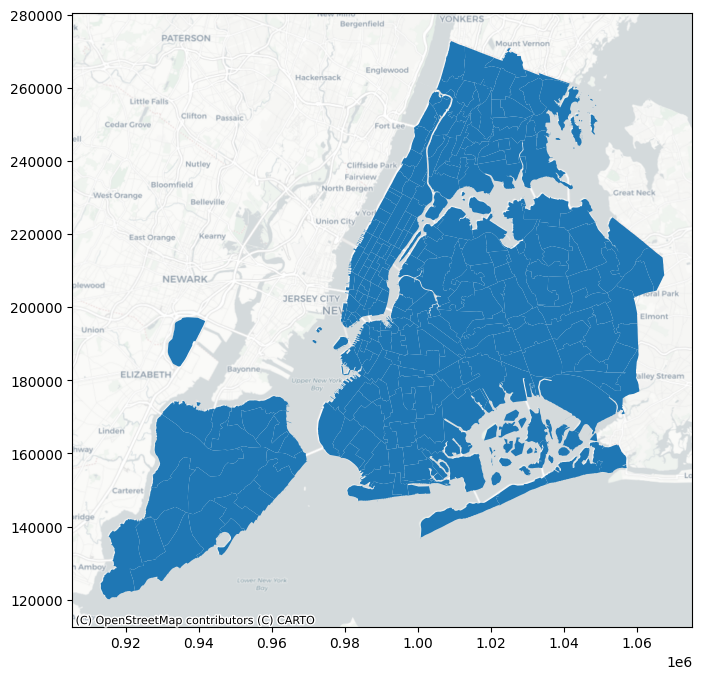

In [26]:
plot_geometry(df_zone)

The 265 zones can also be grouped in 7 districts.

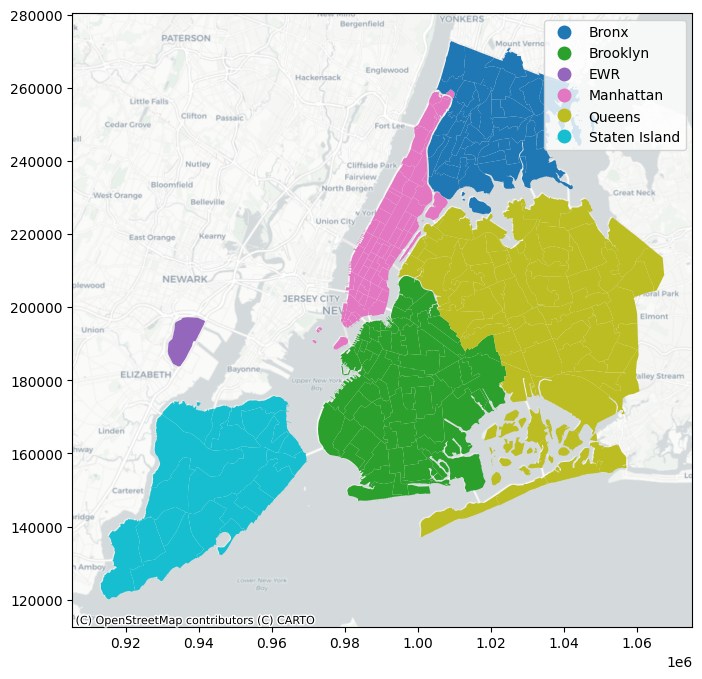

In [27]:
plot_geometry(df_zone, column="Borough")

**Count of taxi trips per zone**

We can count the number of taxi trips per zone by making a groupby on the dataset of the trip, then we add this new feature to the dataset of the zones:

In [28]:
df_zone["PU_count"] = X_train.groupby(by="PULocationID").size()
df_zone["DO_count"] = X_train.groupby(by="DOLocationID").size()

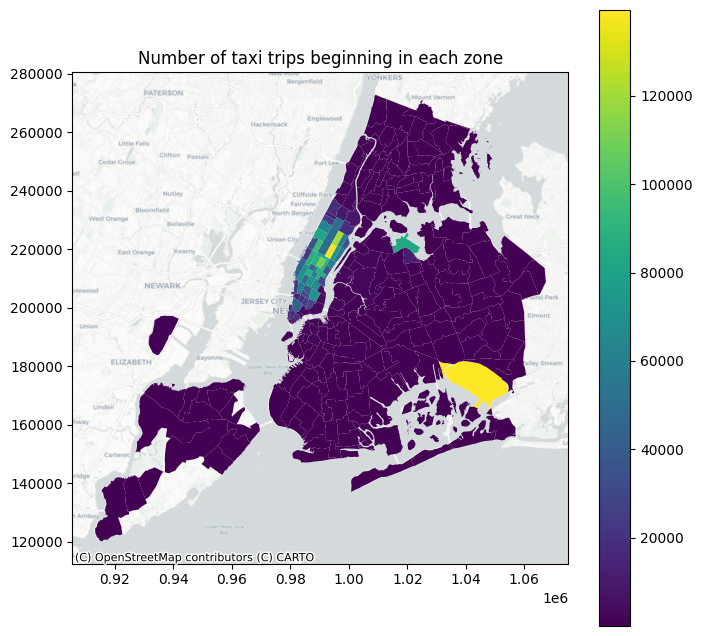

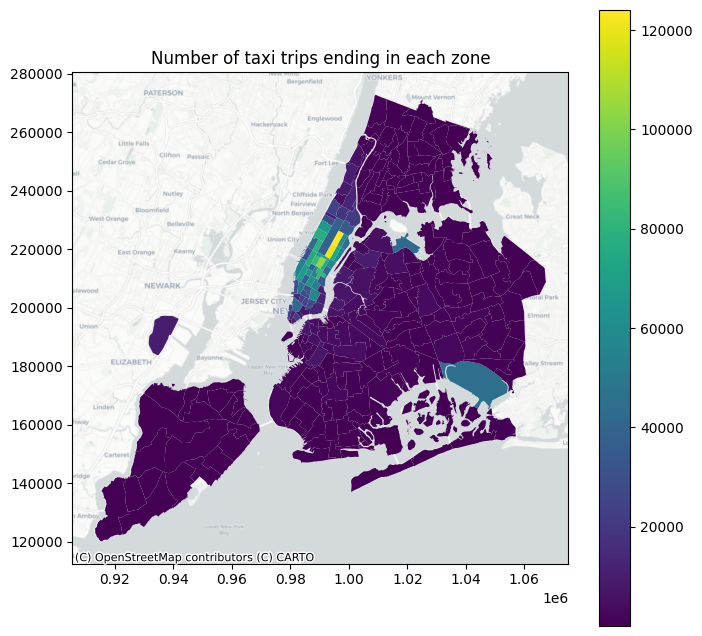

In [29]:
plot_geometry(
    df_zone, column="PU_count", title="Number of taxi trips beginning in each zone"
)
plot_geometry(
    df_zone, column="DO_count", title="Number of taxi trips ending in each zone"
)

**Most frequent journeys by borough**

In [30]:
df = X_train.merge(
    df_zone[["Borough"]].add_prefix("PU"),
    left_on="PULocationID",
    right_index=True,
    how="left",
)
df = df.merge(
    df_zone[["Borough"]].add_prefix("DO"),
    left_on="DOLocationID",
    right_index=True,
    how="left",
)
df = (
    df.groupby(["PUBorough", "DOBorough"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
    .sort_values(by="count", ascending=False)
)
df.head(10)

PUBorough  DOBorough    count
22  Manhattan  Manhattan  2331893
29     Queens  Manhattan   146912
23  Manhattan     Queens   110125
20  Manhattan   Brooklyn    66349
30     Queens     Queens    56187
27     Queens   Brooklyn    36886
46    Unknown    Unknown    16603
43    Unknown  Manhattan    14321
10   Brooklyn  Manhattan    10759
8    Brooklyn   Brooklyn     9953

We can then create a graph by considering the boroughs as the nodes and the count of the trips as an edge attribute.

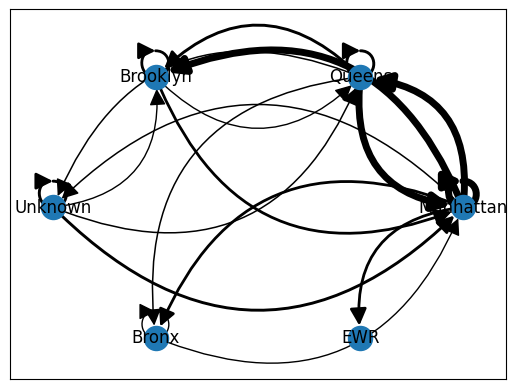

In [31]:
top = df.head(20).copy()
top["width"] = pd.qcut(
    top["count"], q=5, labels=[1.0, 1.1, 2.0, 2.1, 5], duplicates="drop"
)
top["arrow_size"] = 25

G = nx.from_pandas_edgelist(
    top,
    source="PUBorough",
    target="DOBorough",
    edge_attr=["width", "arrow_size"],
    create_using=nx.DiGraph(),
)

pos = nx.circular_layout(G)
widths = nx.get_edge_attributes(G, "width")
arrow_sizes = nx.get_edge_attributes(G, "arrow_size")
nx.draw_networkx(
    G,
    pos=pos,
    arrowsize=list(arrow_sizes.values()),
    width=list(widths.values()),
    connectionstyle="arc3, rad = 0.5",
)
plt.show()

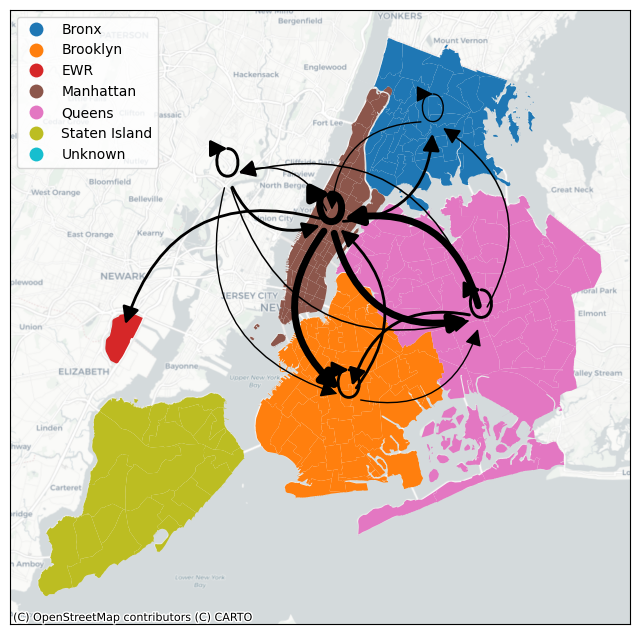

In [32]:
pos = df_zone.dissolve("Borough").centroid.to_dict()

for key, value in pos.items():
    if value is not None:
        pos[key] = np.array([value.x, value.y])
    else:  # Unknown
        pos[key] = np.array([965000, 235000])

widths = nx.get_edge_attributes(G, "width")
arrow_sizes = nx.get_edge_attributes(G, "arrow_size")

ax = df_zone.plot(column="Borough", figsize=(8, 8), legend=True)
nx.draw_networkx_edges(
    G,
    pos=pos,
    arrowsize=list(arrow_sizes.values()),
    width=list(widths.values()),
    connectionstyle="arc3, rad = 0.5",
    ax=ax,
)
cx.add_basemap(ax, crs=df_zone.crs, source="CartoDB positron")

plt.show()

### 4.4.2. Points of intereset (POI) data

To provide additional information on New-York geography, the `get_poi_data` function allows you to recover a dataset of 20k points of interest in New-York with the geographical coordinates.

In [33]:
df_poi = get_poi_data()
df_poi

FACI_DOM        BOROUGH               FACILITY_T  \
0          Tunnel      Manhattan  Transportation Facility   
1          Bridge         Queens  Transportation Facility   
2          Bridge       Brooklyn  Transportation Facility   
3          Bridge      Manhattan  Transportation Facility   
4          Bridge       Brooklyn  Transportation Facility   
...           ...            ...                      ...   
20547  Playground  Staten Island    Recreational Facility   
20548       Beach       Brooklyn    Recreational Facility   
20549  Playground       Brooklyn    Recreational Facility   
20550       Other          Bronx  Transportation Facility   
20551        Park       Brooklyn    Recreational Facility   

                              NAME                        geometry  
0                          HOLLAND   POINT (982304.992 203280.606)  
1                       WHITESTONE  POINT (1032255.829 229759.571)  
2                         BROOKLYN   POINT (985926.229 195707.000)  
3                        MANHATTAN   POINT (986484.168 197803.048)  
4                          PULASKI   POINT (997368.511 208541.834)  
...                            ...                             ...  
20547  WOLFES POND PARK PLAYGROUND   POINT (932175.819 128186.627)  
20548              MANHATTAN BEACH   POINT (999746.393 149198.683)  
20549       PAT PERLATO PLAYGROUND   POINT (999050.646 149511.617)  
20550         NYPD BRONX TOW POUND  POINT (1009112.693 254928.317)  
20551         MANHATTAN BEACH PARK  POINT (1000058.525 149358.135)  

[20552 rows x 5 columns]

Each point of interest is classified in a main category `FACILITY_T` with 13 modalities and in a `FACI_DOM` subcategory depending on the first one.

In [34]:
def plot_cat(df, feature, normalize=True, order=None, rotation=None, title=None):
    if normalize:
        ylabel = "Frequency (%)"
    else:
        ylabel = "Count"
    prct_df = df[feature].value_counts(normalize=normalize).rename(ylabel).reset_index()
    if normalize:
        prct_df[ylabel] = prct_df[ylabel] * 100
    sns.barplot(
        data=prct_df, x="index", y=ylabel, color="tab:blue", saturation=1, order=order
    ).set(xlabel=feature)
    plt.grid(axis="y")
    if rotation is not None:
        plt.xticks(rotation=rotation, ha="right", rotation_mode="anchor")
    if title is not None:
        plt.title(title)
    plt.show()

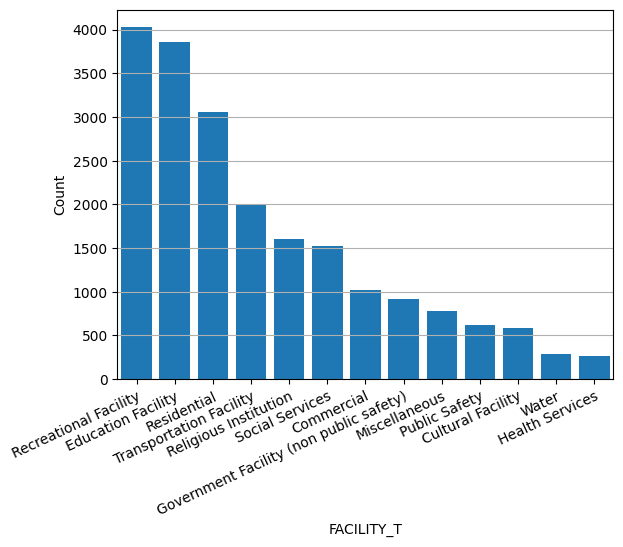

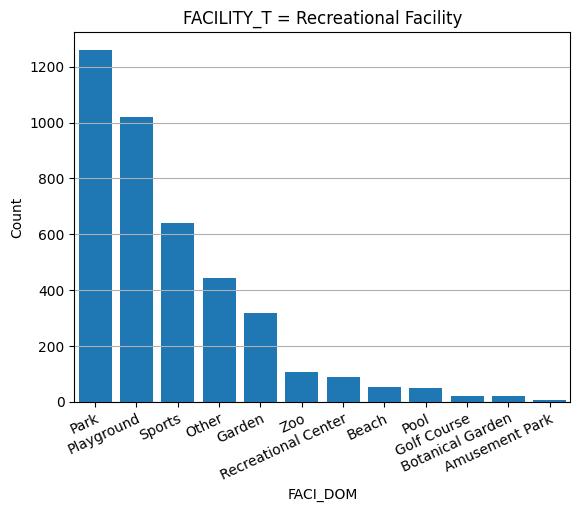

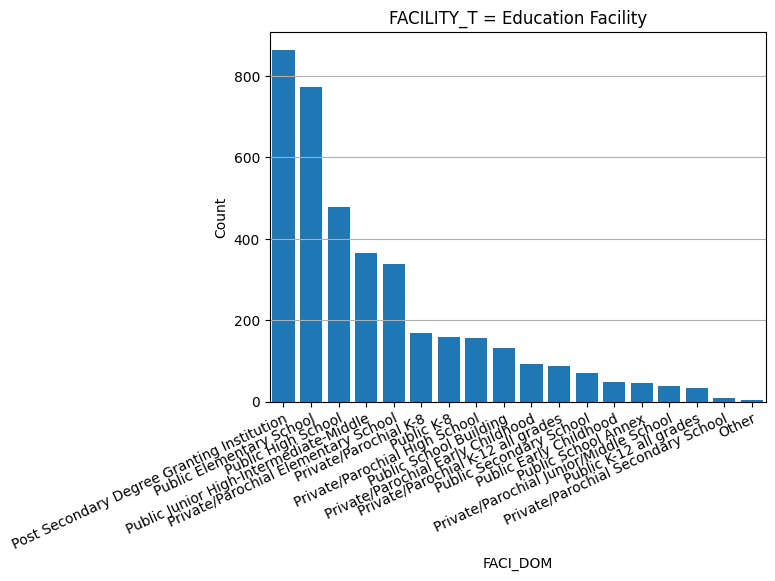

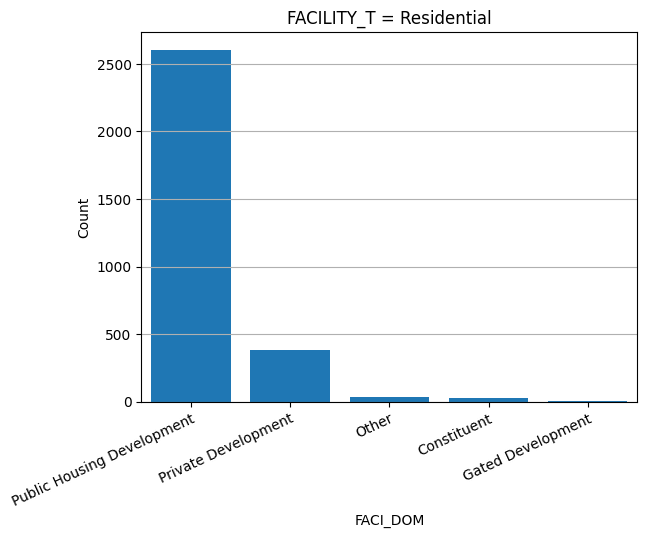

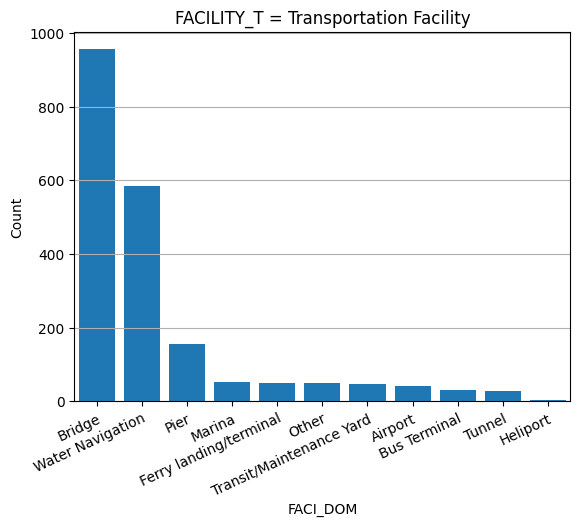

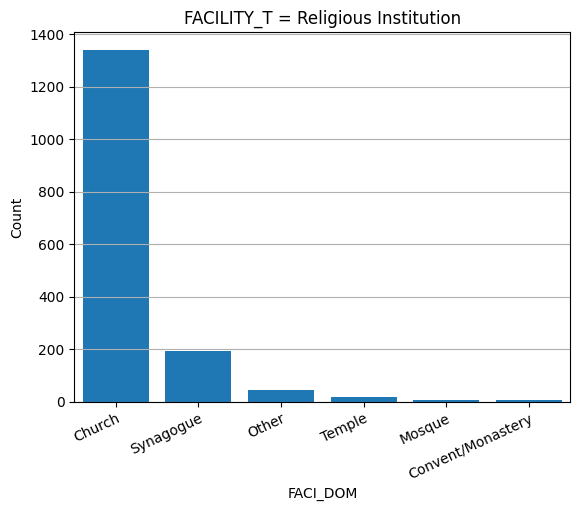

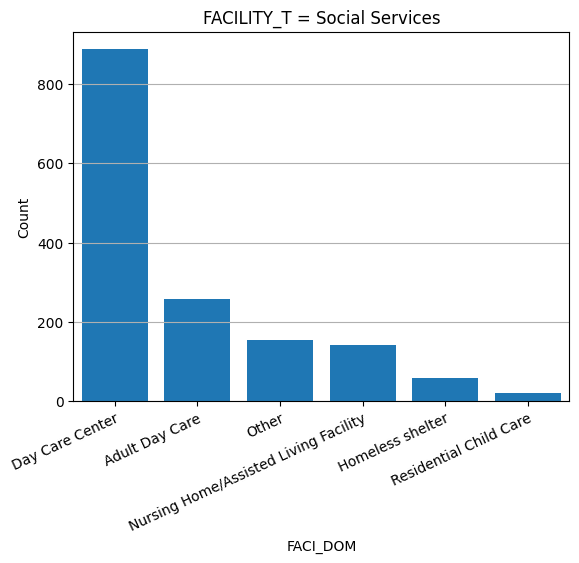

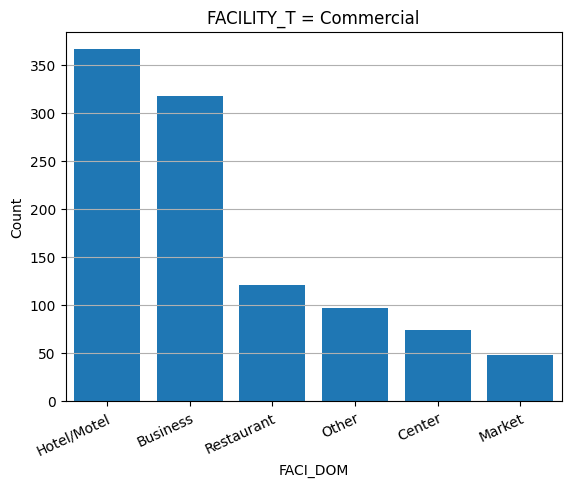

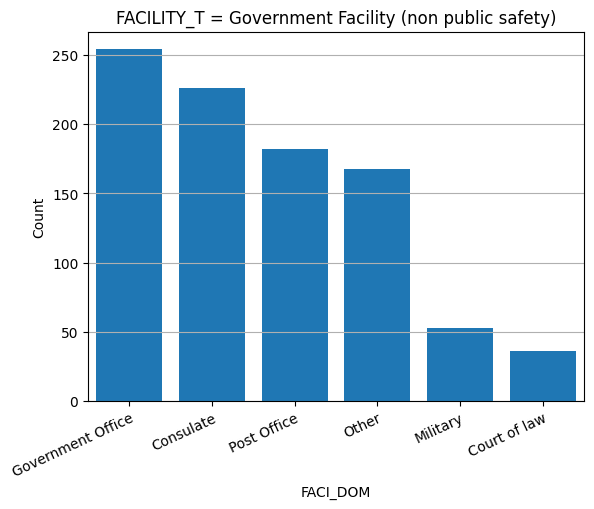

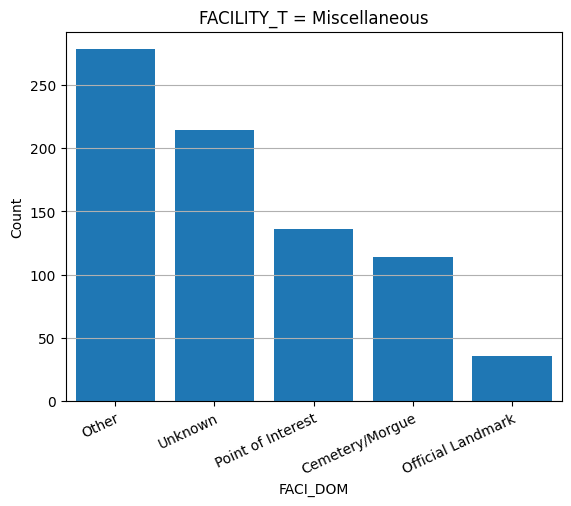

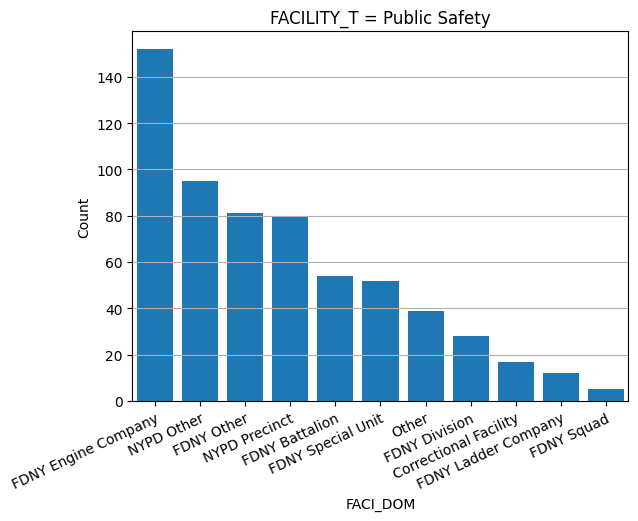

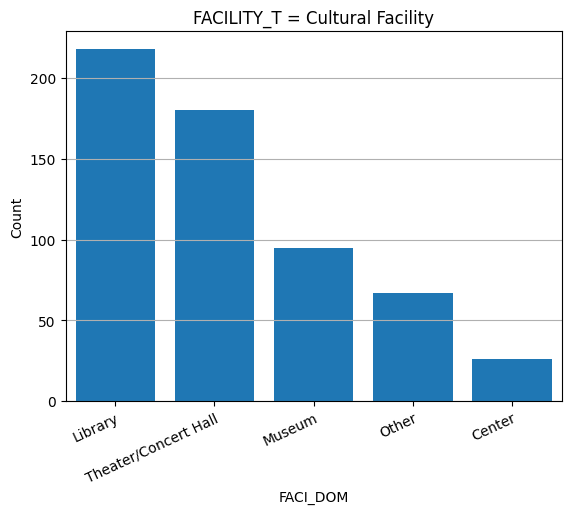

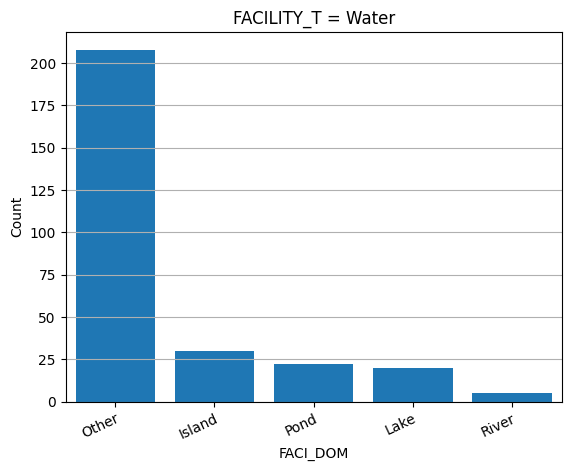

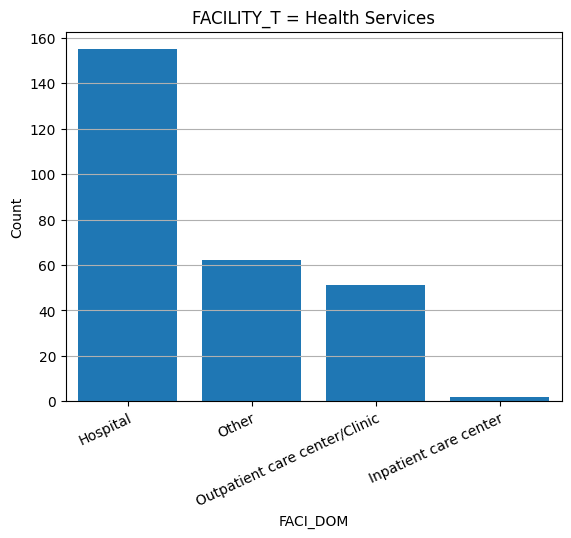

In [35]:
plot_cat(df_poi, "FACILITY_T", normalize=False, rotation=25)

for facility_t in df_poi["FACILITY_T"].value_counts().index:
    plot_cat(
        df_poi[df_poi["FACILITY_T"] == facility_t],
        "FACI_DOM",
        normalize=False,
        rotation=25,
        title=f"FACILITY_T = {facility_t}",
    )

Each point of interest is associated with a geographical coordinate, which makes it possible to create a map of the POI :

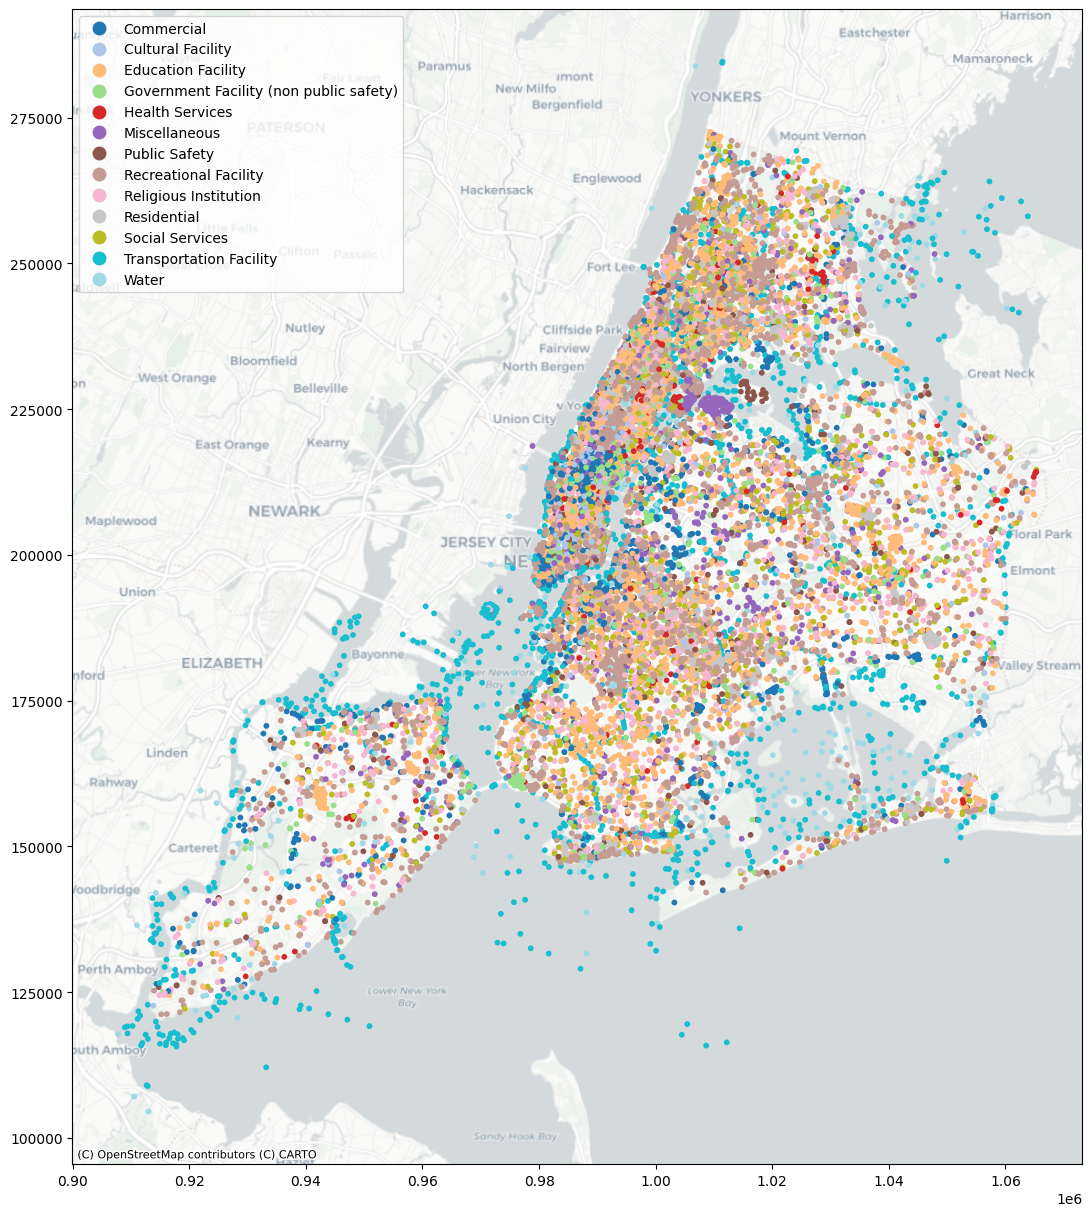

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_geometry(
    df_poi, column="FACILITY_T", cmap="tab20", interactive=False, markersize=10, ax=ax
)

Thanks to the categories, we can filter the POIs, for example here we display only the transportation facilities (`FACILITY_T == "Transportation Facility"`) and the colors correspond to the subcategories (`FACI_DOM`)

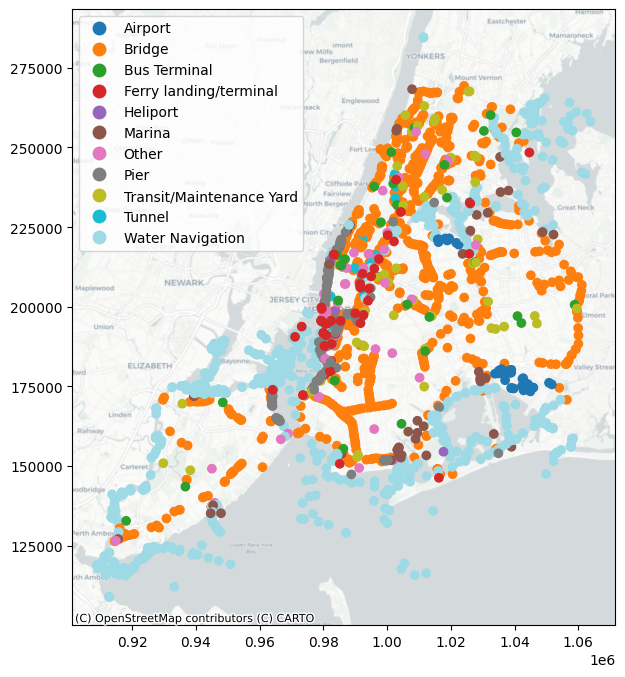

In [37]:
plot_geometry(
    df_poi[df_poi["FACILITY_T"] == "Transportation Facility"],
    column="FACI_DOM",
    cmap="tab20",
)

### 4.4.3. Adding POI features to the zone dataset

We can now merge the zone data and POI data by creating new features characterizing each zone according to the POIs it has.

First of all we create a `LocationID` variable in the POI dataset which indicates in which zone each POI is located.

In [38]:
df_poi = gpd.sjoin(df_poi, df_zone[["geometry"]], predicate="within", how="left")
df_poi = df_poi.rename(columns={"index_right": "LocationID"})
df_poi["LocationID"] = df_poi["LocationID"].astype("Int64")
df_poi

FACI_DOM        BOROUGH               FACILITY_T  \
0          Tunnel      Manhattan  Transportation Facility   
1          Bridge         Queens  Transportation Facility   
2          Bridge       Brooklyn  Transportation Facility   
3          Bridge      Manhattan  Transportation Facility   
4          Bridge       Brooklyn  Transportation Facility   
...           ...            ...                      ...   
20547  Playground  Staten Island    Recreational Facility   
20548       Beach       Brooklyn    Recreational Facility   
20549  Playground       Brooklyn    Recreational Facility   
20550       Other          Bronx  Transportation Facility   
20551        Park       Brooklyn    Recreational Facility   

                              NAME                        geometry  LocationID  
0                          HOLLAND   POINT (982304.992 203280.606)         125  
1                       WHITESTONE  POINT (1032255.829 229759.571)         252  
2                         BROOKLYN   POINT (985926.229 195707.000)          66  
3                        MANHATTAN   POINT (986484.168 197803.048)         232  
4                          PULASKI   POINT (997368.511 208541.834)        <NA>  
...                            ...                             ...         ...  
20547  WOLFES POND PARK PLAYGROUND   POINT (932175.819 128186.627)          84  
20548              MANHATTAN BEACH   POINT (999746.393 149198.683)         150  
20549       PAT PERLATO PLAYGROUND   POINT (999050.646 149511.617)         150  
20550         NYPD BRONX TOW POUND  POINT (1009112.693 254928.317)         136  
20551         MANHATTAN BEACH PARK  POINT (1000058.525 149358.135)         150  

[20552 rows x 6 columns]

It is now possible to perform groupby commands on the POI dataset by `LocationID`.

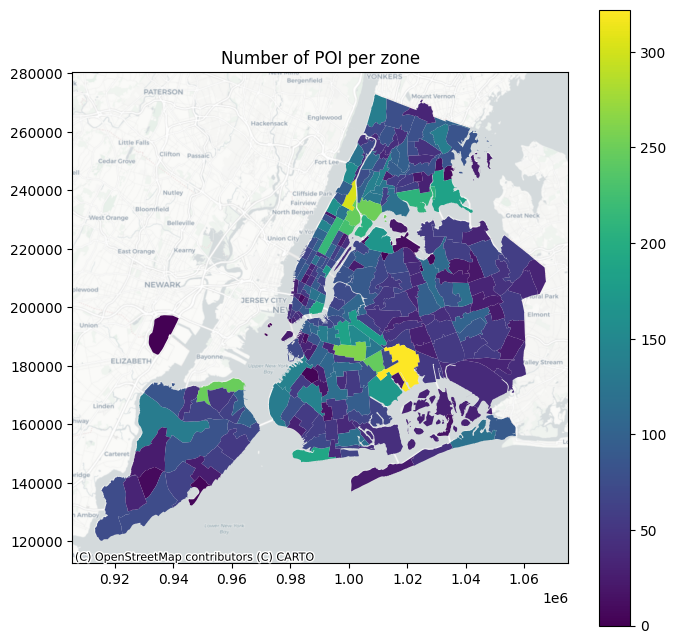

In [39]:
df_zone["POI_count"] = df_poi.groupby("LocationID").size()
df_zone["POI_count"] = df_zone["POI_count"].fillna(0)
plot_geometry(df_zone, column="POI_count", title="Number of POI per zone")

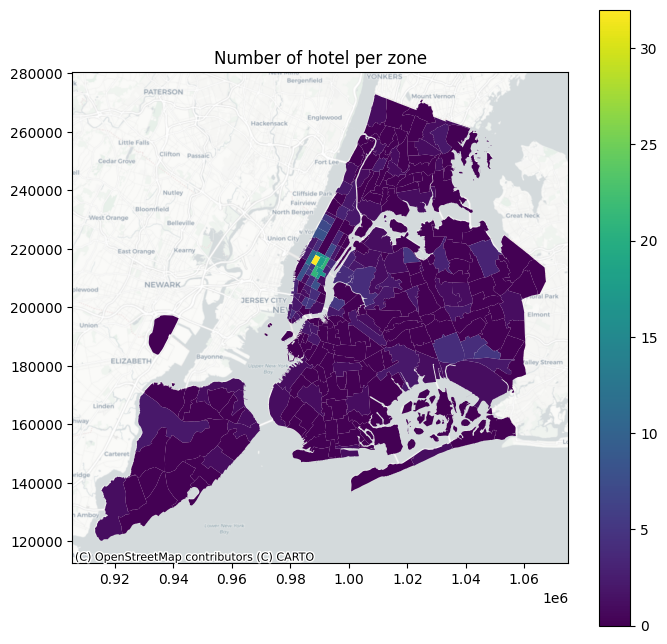

In [40]:
df_zone["Hotel_count"] = (
    df_poi[df_poi["FACI_DOM"] == "Hotel/Motel"].groupby("LocationID").size()
)
df_zone["Hotel_count"] = df_zone["Hotel_count"].fillna(0)
plot_geometry(df_zone, column="Hotel_count", title="Number of hotel per zone")

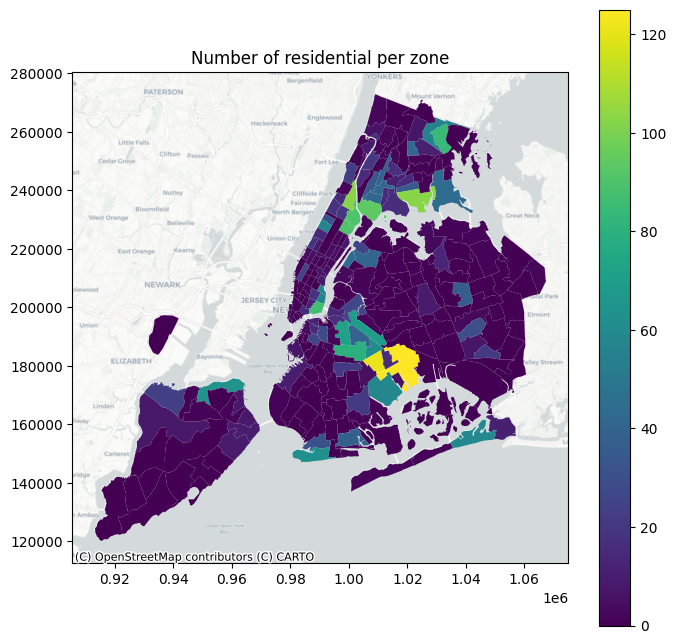

In [41]:
df_zone["Residential_count"] = (
    df_poi[df_poi["FACILITY_T"] == "Residential"].groupby("LocationID").size()
)
df_zone["Residential_count"] = df_zone["Residential_count"].fillna(0)
plot_geometry(
    df_zone, column="Residential_count", title="Number of residential per zone"
)

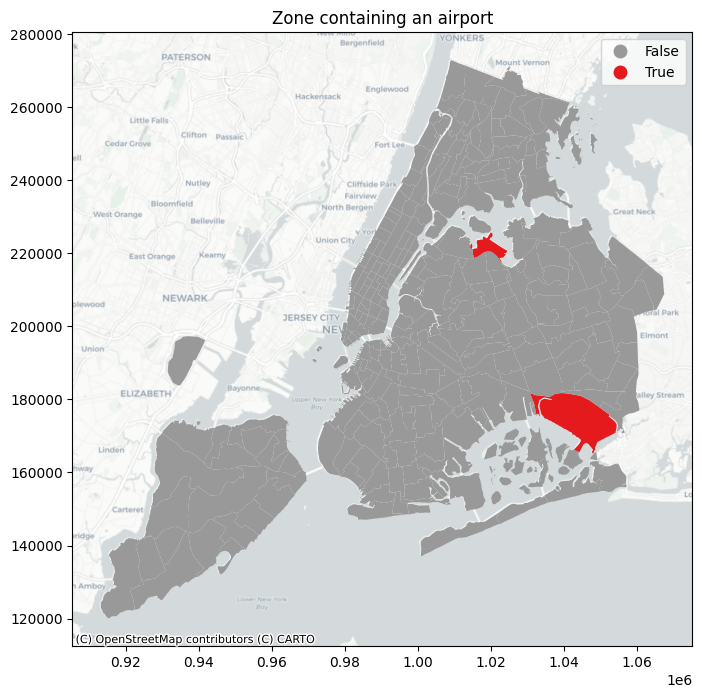

In [42]:
df_zone["has_airport"] = (
    df_poi[df_poi["FACI_DOM"] == "Airport"].groupby("LocationID").size()
)
df_zone["has_airport"] = df_zone["has_airport"].fillna(0) > 1
plot_geometry(
    df_zone, column="has_airport", title="Zone containing an airport", cmap="Set1_r"
)

## 4.5. Weather Data 

One way to enhance our features and dataset is to add new data like we did with the point of interest. We found a valuable csv files containing hourly weather report in New York City. One improvement would be to find more granular data to model the exact weather on a district level. 

In the next cells, we will merge the two dataframes and only focus on the temperature and the precipitation level.

In [43]:
df_precipitation = get_weather_data()
df_precipitation

temp  prcp
time                           
2022-05-01 00:00:00  11.1   0.0
2022-05-01 01:00:00  10.6   0.0
2022-05-01 02:00:00   8.9   0.0
2022-05-01 03:00:00   8.9   0.0
2022-05-01 04:00:00   8.9   0.0
...                   ...   ...
2022-05-31 19:00:00  33.9   0.0
2022-05-31 20:00:00  33.3   0.0
2022-05-31 21:00:00  33.3   0.0
2022-05-31 22:00:00  26.1   0.0
2022-05-31 23:00:00  22.8   0.0

[744 rows x 2 columns]

In [44]:
X_train = X_train.merge(
    df_precipitation,
    how="left",
    left_on=X_train.tpep_pickup_datetime.dt.floor("h"),
    right_index=True,
)
X_train

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2022-05-12 21:19:50   2022-05-12 21:23:46              1.0   
1               2  2022-05-03 15:21:34   2022-05-03 15:28:56              1.0   
2               2  2022-05-10 10:50:21   2022-05-10 11:06:07              1.0   
3               1  2022-05-15 12:28:05   2022-05-15 12:49:04              1.0   
4               2  2022-05-16 00:41:32   2022-05-16 00:51:44              1.0   
...           ...                  ...                   ...              ...   
2852939         2  2022-05-01 17:59:45   2022-05-01 18:05:27              1.0   
2852940         2  2022-05-31 20:50:54   2022-05-31 20:59:22              2.0   
2852941         2  2022-05-28 16:51:19   2022-05-28 17:11:36              2.0   
2852942         2  2022-05-28 15:15:53   2022-05-28 15:27:22              1.0   
2852943         2  2022-05-19 07:31:38   2022-05-19 07:49:43              1.0   

         PULocationID  DOLocationID  fg_weekends  fg_bank_holidays  \
0                  90           158        False             False   
1                  48           246        False             False   
2                 141           162        False             False   
3                 148           186         True             False   
4                 246            48        False             False   
...               ...           ...          ...               ...   
2852939           151           142         True             False   
2852940            43           263        False             False   
2852941           161           148         True             False   
2852942            48           142         True             False   
2852943           148            43        False             False   

         fg_overnight  fg_rush_hour  temp  prcp  
0                True         False  16.7   0.0  
1               False         False  16.7   0.0  
2               False         False  19.4   0.0  
3               False         False  24.4   0.0  
4                True         False  20.6   0.0  
...               ...           ...   ...   ...  
2852939         False         False  17.8   0.0  
2852940         False         False  33.3   0.0  
2852941         False         False  23.9   0.0  
2852942         False         False  23.9   0.0  
2852943         False         False  13.3   4.6  

[2852944 rows x 12 columns]

# 5. The pipeline

In [45]:
X_train, y_train = get_train_data()

## 5.1. Adding geographic features

We have previously calculated features for each zone (area, number of POIs inside, number of hotels, presence of an airport).
To add these features to the trip data, we note that each trip is characterized by 2 zones: the pickup departure zone (`PULocationID`) and the dropoff arrival zone (`DOLocationID`). We will add these characteristics for each of the 2 zones.

In [46]:
class GeoFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, get_poi_data, get_zone_data):
        super().__init__()

        self.get_poi_data = get_poi_data
        self.get_zone_data = get_zone_data

        df_zone = get_zone_data()
        df_poi = get_poi_data()

        df_poi = gpd.sjoin(
            df_poi, df_zone[["geometry"]], predicate="within", how="left"
        )
        df_poi = df_poi.rename(columns={"index_right": "LocationID"})
        df_poi["LocationID"] = df_poi["LocationID"].astype("Int64")

        df_zone["POI_count"] = df_poi.groupby("LocationID").size()
        df_zone["POI_count"] = df_zone["POI_count"].fillna(0)

        df_zone["Hotel_count"] = (
            df_poi[df_poi["FACI_DOM"] == "Hotel/Motel"].groupby("LocationID").size()
        )
        df_zone["Hotel_count"] = df_zone["Hotel_count"].fillna(0)

        df_zone["Residential_count"] = (
            df_poi[df_poi["FACILITY_T"] == "Residential"].groupby("LocationID").size()
        )
        df_zone["Residential_count"] = df_zone["Residential_count"].fillna(0)

        df_zone["has_airport"] = (
            df_poi[df_poi["FACI_DOM"] == "Airport"].groupby("LocationID").size()
        )
        df_zone["has_airport"] = df_zone["has_airport"].fillna(0) > 1

        self.df_zone = df_zone

    def fit(self, X, y):
        return self

    def transform(self, X):
        X = X.copy()
        columns_to_add = [
            "Borough",
            "Zone",
            "service_zone",
            "Shape_Leng",
            "Shape_Area",
            "POI_count",
            "Hotel_count",
            "Residential_count",
            "has_airport",
        ]
        X = X.merge(
            self.df_zone[columns_to_add].add_prefix("PU"),
            left_on="PULocationID",
            right_index=True,
            how="left",
        )
        X = X.merge(
            self.df_zone[columns_to_add].add_prefix("DO"),
            left_on="DOLocationID",
            right_index=True,
            how="left",
        )
        return X

In [47]:
geographic_feature_extractor = GeoFeatureExtractor(get_poi_data, get_zone_data)
X_train = geographic_feature_extractor.transform(X_train)
X_train

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2022-05-12 21:19:50   2022-05-12 21:23:46              1.0   
1               2  2022-05-03 15:21:34   2022-05-03 15:28:56              1.0   
2               2  2022-05-10 10:50:21   2022-05-10 11:06:07              1.0   
3               1  2022-05-15 12:28:05   2022-05-15 12:49:04              1.0   
4               2  2022-05-16 00:41:32   2022-05-16 00:51:44              1.0   
...           ...                  ...                   ...              ...   
2852939         2  2022-05-01 17:59:45   2022-05-01 18:05:27              1.0   
2852940         2  2022-05-31 20:50:54   2022-05-31 20:59:22              2.0   
2852941         2  2022-05-28 16:51:19   2022-05-28 17:11:36              2.0   
2852942         2  2022-05-28 15:15:53   2022-05-28 15:27:22              1.0   
2852943         2  2022-05-19 07:31:38   2022-05-19 07:49:43              1.0   

         PULocationID  DOLocationID  PUBorough                     PUZone  \
0                  90           158  Manhattan                   Flatiron   
1                  48           246  Manhattan               Clinton East   
2                 141           162  Manhattan            Lenox Hill West   
3                 148           186  Manhattan            Lower East Side   
4                 246            48  Manhattan  West Chelsea/Hudson Yards   
...               ...           ...        ...                        ...   
2852939           151           142  Manhattan           Manhattan Valley   
2852940            43           263  Manhattan               Central Park   
2852941           161           148  Manhattan             Midtown Center   
2852942            48           142  Manhattan               Clinton East   
2852943           148            43  Manhattan            Lower East Side   

        PUservice_zone  PUShape_Leng  ...  PUhas_airport  DOBorough  \
0          Yellow Zone      0.030759  ...          False  Manhattan   
1          Yellow Zone      0.043747  ...          False  Manhattan   
2          Yellow Zone      0.041514  ...          False  Manhattan   
3          Yellow Zone      0.039131  ...          False  Manhattan   
4          Yellow Zone      0.069467  ...          False  Manhattan   
...                ...           ...  ...            ...        ...   
2852939    Yellow Zone      0.054890  ...          False  Manhattan   
2852940    Yellow Zone      0.099739  ...          False  Manhattan   
2852941    Yellow Zone      0.035804  ...          False  Manhattan   
2852942    Yellow Zone      0.043747  ...          False  Manhattan   
2852943    Yellow Zone      0.039131  ...          False  Manhattan   

                                DOZone  DOservice_zone  DOShape_Leng  \
0        Meatpacking/West Village West     Yellow Zone      0.054810   
1            West Chelsea/Hudson Yards     Yellow Zone      0.069467   
2                         Midtown East     Yellow Zone      0.035270   
3         Penn Station/Madison Sq West     Yellow Zone      0.024696   
4                         Clinton East     Yellow Zone      0.043747   
...                                ...             ...           ...   
2852939            Lincoln Square East     Yellow Zone      0.038176   
2852940                 Yorkville West     Yellow Zone      0.037017   
2852941                Lower East Side     Yellow Zone      0.039131   
2852942            Lincoln Square East     Yellow Zone      0.038176   
2852943                   Central Park     Yellow Zone      0.099739   

        DOShape_Area DOPOI_count DOHotel_count  DOResidential_count  \
0           0.000186        27.0           3.0                  0.0   
1           0.000281        82.0           0.0                  0.0   
2           0.000048        73.0          21.0                  2.0   
3           0.000037        36.0           5.0                  0.0   
4           0.000094        76.0      

## 5.2. Adding weather features

In [48]:
class WeatherFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, get_weather_data):
        super().__init__()

        self.get_weather_data = get_weather_data

        df_precipitation = get_weather_data()
        self.df_precipitation = df_precipitation

    def fit(self, X, y):
        return self

    def transform(self, X):
        X = X.copy()
        columns_to_add = ["temp", "prcp"]
        X = X.merge(
            self.df_precipitation[columns_to_add],
            left_on=X.tpep_pickup_datetime.dt.floor("h"),
            right_index=True,
            how="left",
        )
        return X

In [49]:
weather_feature_extractor = WeatherFeatureExtractor(get_weather_data)
X_train = weather_feature_extractor.transform(X_train)
X_train

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2022-05-12 21:19:50   2022-05-12 21:23:46              1.0   
1               2  2022-05-03 15:21:34   2022-05-03 15:28:56              1.0   
2               2  2022-05-10 10:50:21   2022-05-10 11:06:07              1.0   
3               1  2022-05-15 12:28:05   2022-05-15 12:49:04              1.0   
4               2  2022-05-16 00:41:32   2022-05-16 00:51:44              1.0   
...           ...                  ...                   ...              ...   
2852939         2  2022-05-01 17:59:45   2022-05-01 18:05:27              1.0   
2852940         2  2022-05-31 20:50:54   2022-05-31 20:59:22              2.0   
2852941         2  2022-05-28 16:51:19   2022-05-28 17:11:36              2.0   
2852942         2  2022-05-28 15:15:53   2022-05-28 15:27:22              1.0   
2852943         2  2022-05-19 07:31:38   2022-05-19 07:49:43              1.0   

         PULocationID  DOLocationID  PUBorough                     PUZone  \
0                  90           158  Manhattan                   Flatiron   
1                  48           246  Manhattan               Clinton East   
2                 141           162  Manhattan            Lenox Hill West   
3                 148           186  Manhattan            Lower East Side   
4                 246            48  Manhattan  West Chelsea/Hudson Yards   
...               ...           ...        ...                        ...   
2852939           151           142  Manhattan           Manhattan Valley   
2852940            43           263  Manhattan               Central Park   
2852941           161           148  Manhattan             Midtown Center   
2852942            48           142  Manhattan               Clinton East   
2852943           148            43  Manhattan            Lower East Side   

        PUservice_zone  PUShape_Leng  ...                         DOZone  \
0          Yellow Zone      0.030759  ...  Meatpacking/West Village West   
1          Yellow Zone      0.043747  ...      West Chelsea/Hudson Yards   
2          Yellow Zone      0.041514  ...                   Midtown East   
3          Yellow Zone      0.039131  ...   Penn Station/Madison Sq West   
4          Yellow Zone      0.069467  ...                   Clinton East   
...                ...           ...  ...                            ...   
2852939    Yellow Zone      0.054890  ...            Lincoln Square East   
2852940    Yellow Zone      0.099739  ...                 Yorkville West   
2852941    Yellow Zone      0.035804  ...                Lower East Side   
2852942    Yellow Zone      0.043747  ...            Lincoln Square East   
2852943    Yellow Zone      0.039131  ...                   Central Park   

         DOservice_zone  DOShape_Leng  DOShape_Area  DOPOI_count  \
0           Yellow Zone      0.054810      0.000186         27.0   
1           Yellow Zone      0.069467      0.000281         82.0   
2           Yellow Zone      0.035270      0.000048         73.0   
3           Yellow Zone      0.024696      0.000037         36.0   
4           Yellow Zone      0.043747      0.000094         76.0   
...                 ...           ...           ...          ...   
2852939     Yellow Zone      0.038176      0.000076        100.0   
2852940     Yellow Zone      0.037017      0.000066         22.0   
2852941     Yellow Zone      0.039131      0.000070         75.0   
2852942     Yellow Zone      0.038176      0.000076        100.0   
2852943     Yellow Zone      0.099739      0.000380        216.0   

        DOHotel_count DOResidential_count DOhas_airport  temp  prcp  
0                 3.0                 0.0         False  16.7   0.0  
1                 0.0                 0.0         False  16.7   0.0  
2                21.0                 2.0         False  19.4   0.0  
3                 5.0                 0.0         False  24.4   0.0  
4                12.0          

## 5.3. Complete pipeline

In [50]:
X_train, y_train = get_train_data()

In [51]:
FEATURES = [
    # 'VendorID',
    # 'tpep_pickup_datetime',
    # 'tpep_dropoff_datetime',
    "passenger_count",
    #    'PULocationID',
    #    'DOLocationID',
    #    'PUBorough',
    #    'PUZone',
    #    'PUservice_zone',
    "PUShape_Leng",
    "PUShape_Area",
    "PUPOI_count",
    "PUHotel_count",
    "PUResidential_count",
    "PUhas_airport",
    #    'DOBorough',
    #    'DOZone',
    #    'DOservice_zone',
    "DOShape_Leng",
    "DOShape_Area",
    "DOPOI_count",
    "DOHotel_count",
    "DOResidential_count",
    "DOhas_airport",
    "temp",
    "prcp",
]


class FeatureSelector(BaseEstimator, TransformerMixin):
    """Select some features."""

    def __init__(self, features):
        if not isinstance(features, list):
            self.features = [features]
        else:
            self.features = features

    def fit(self, X, y):
        return self

    def transform(self, X):
        X = X.copy()
        return X[self.features]

In [52]:
def get_estimator(get_poi_data, get_weather_data, get_zone_data):
    geographic_feature_extractor = GeoFeatureExtractor(get_poi_data, get_zone_data)
    weather_feature_extractor = WeatherFeatureExtractor(get_weather_data)
    features_selector = FeatureSelector(features=FEATURES)

    # Replace NaN values
    imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

    regressor = LinearRegression()

    pipe = make_pipeline(
        geographic_feature_extractor,
        weather_feature_extractor,
        features_selector,
        imputer,
        regressor,
    )

    return pipe


model = get_estimator(get_poi_data, get_weather_data, get_zone_data)
model

Pipeline(steps=[('geofeatureextractor',
                 GeoFeatureExtractor(get_poi_data=<function get_poi_data at 0x00000212A6C437F0>,
                                     get_zone_data=<function get_zone_data at 0x00000212A6C43760>)),
                ('weatherfeatureextractor',
                 WeatherFeatureExtractor(get_weather_data=<function get_weather_data at 0x00000212A6C435B0>)),
                ('featureselector',
                 FeatureSelector(features=['passenger_count', 'PUShape_Leng',
                                           'PUShape_Area', 'PUPOI_count',
                                           'PUHotel_count',
                                           'PUResidential_count',
                                           'PUhas_airport', 'DOShape_Leng',
                                           'DOShape_Area', 'DOPOI_count',
                                           'DOHotel_count',
                                           'DOResidential_count',
                                           'DOhas_airport', 'temp', 'prcp'])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('linearregression', LinearRegression())])

In [53]:
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
y_pred

array([22.50975731, 21.01160235, 17.35903113, ..., 17.72814284,
       17.16911061, 15.67639584])

# 6. Evaluation

We are using evaluation function already implemented in the rampwf library : the RMSE and the Normalized RMSE

In [54]:
def RMSE(y_true, y_pred):
    score = rw.score_types.RMSE(name="rmse", precision=3)
    return score(np.asarray(y_true), np.asarray(y_pred))


def NormalizedRMSE(y_true, y_pred):
    score = rw.score_types.NormalizedRMSE(name="normalized_rmse", precision=3)
    return score(np.asarray(y_true), np.asarray(y_pred))

In [55]:
print(f"RMSE : {RMSE(y_train, y_pred):.4f}")
print(f"Normalized RMSE : {NormalizedRMSE(y_train, y_pred):.4f}")

RMSE : 12.9912
Normalized RMSE : 0.7293


# 7. Testing the submission

You can test locally our pipeline using ramp_test_submission command line (-h will give you all infos). For that, open a terminal in your taxi-fare-predicition/ folder and type on a terminal ramp_test_submission --submission starting_kit. You can then copy a submission example in submissions/<YOUR_SUBMISSION_NAME>/and modify its codes as you want. Finally, test it on your computer with ramp_test_submission --submission <YOUR_SUBMISSION_NAME>.

If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.


# 8. Submission

Once you have found a good model, you can submit them to ramp.studio to enter the online challenge. First, if it is your first time using the RAMP platform, sign up, otherwise log in. Then sign up to the event. Sign up for the event. Both signups are controled by RAMP administrators, so there can be a delay between asking for signup and being able to submit.

Once your signup request is accepted, you can go to your sandbox and copy-paste (or upload) your python files. Save it, rename it, then submit it. The submission is trained and tested on our backend in the similar way as ramp_test_submission does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in my submissions. Once it is trained your submission shows up on the public leaderboard. If there is an error (despite having tested your submission locally with ramp_test_submission), it will show up in the "Failed submissions" table in my submissions. You can click on the error to see part of the trace.

After submission, do not forget to give credit to the previous submissions you reused or integrated into your submission.

The data set we use on the backend is usually different from what you find in the starting kit, so the score may be different.